## Isabella Salgado - 201730418

## Juan Pablo Naranjo - 201730006

# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **20 de septiembre** y se realizará a través de Bloque Neón.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
heart_df=pd.read_csv("heartDisease/framingham.csv")
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

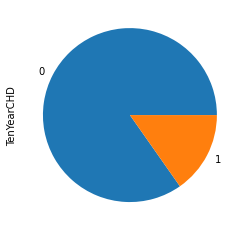

In [ ]:
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [ ]:
x = heart_df.values
scaler = MinMaxScaler() # Utilice un MinMaxScaler en esta ocasión #
x_scaled = scaler.fit_transform(x) # Aplique el escalamiento #
heart_df_scaled = pd.DataFrame(x_scaled, columns=heart_df.columns) # Conversión a un DataFrame #

In [ ]:
x = heart_df_scaled.iloc[:,:-1]
y = heart_df_scaled.iloc[:,-1]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=22)

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [ ]:
logreg = LogisticRegression() # Modelo de Regresión Logística #
logreg.fit(x_train, y_train) # Entrenamiento sobre los Datos #
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {accuracy_score(y_test, y_pred)}')

Precisión inicial: 0.844


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.

Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

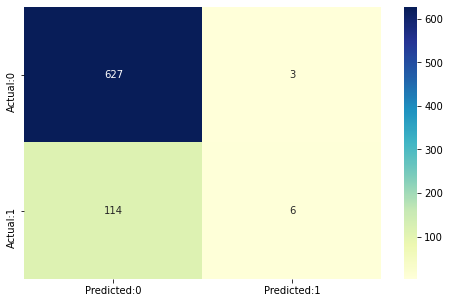

In [ ]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [ ]:
from sklearn.preprocessing import binarize

umbrales = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Vector que Contiene los Umbrales a Analizar #

for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test) # Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    y_pred2 = binarize(y_pred_prob_yes, threshold=umbral) # Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    cm2 = confusion_matrix(y_test, y_pred2[:,1])
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos negativos.
Sensitividad (Recall): {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')


->Para un umbral de 0.1 tenemos esta matriz de confusión:
[[309 321]
 [ 18 102]]
Con 411 predicciones correctas y 18 falsos negativos.
Sensitividad (Recall): 0.85 Especificidad: 0.4905

->Para un umbral de 0.2 tenemos esta matriz de confusión:
[[512 118]
 [ 62  58]]
Con 570 predicciones correctas y 62 falsos negativos.
Sensitividad (Recall): 0.4833 Especificidad: 0.8127

->Para un umbral de 0.3 tenemos esta matriz de confusión:
[[583  47]
 [ 94  26]]
Con 609 predicciones correctas y 94 falsos negativos.
Sensitividad (Recall): 0.2167 Especificidad: 0.9254

->Para un umbral de 0.4 tenemos esta matriz de confusión:
[[614  16]
 [104  16]]
Con 630 predicciones correctas y 104 falsos negativos.
Sensitividad (Recall): 0.1333 Especificidad: 0.9746

->Para un umbral de 0.5 tenemos esta matriz de confusión:
[[627   3]
 [114   6]]
Con 633 predicciones correctas y 114 falsos negativos.
Sensitividad (Recall): 0.05 Especificidad: 0.9952

->Para un umbral de 0.6 tenemos esta matriz de confusión:
[[62

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

AUC = 0.7342



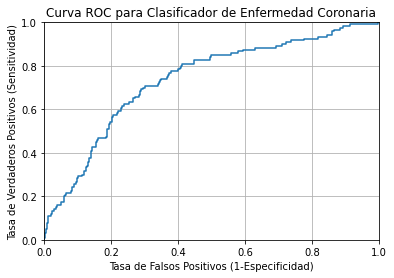

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
print(f'AUC = {np.round(metrics.auc(fpr, tpr), 4)}\n')
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

indices = []
for i in range(len(fpr)):
    if fpr[i] >= 0.40634920634920635 and fpr[i] <= 0.43:
        indices.append(i) 

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

A partir de la gráfica y con respecto al problema de clasificación de nuestro contexto, se puede decir que una buena proporción de TPR y FPR para elegir sería en un punto de la cruva ROC en el que haya una baja tasa de falsos negativos, es decir, un tasa alta de positivos verdaderos. Este lugar en la curva ROC corresponde al lugar más alto posible en el eje $y$ (TPR). Esto se debe al hecho de que indicar que un paciente no está enfermo cuando en verdad sí lo está puede conllevar a consecuencias graves como la muerte de estas personas, demandas penales o costos económicos altos.

También es importante mencionar que un falso positivo en nuestro caso no conlleva a consecuencias tan graves como el caso anterior, pues marcar como enfermo a alguien que verdaderamente no lo está no conlleva a la muerte del paciente y no es tan probable que se generen demandas por esta razón, por ejemplo. Sin embargo, también es mejor mantener la tasa de falsos positivos alejada del 1, para que el clasificador no se equivoque asignando los negativos verdaderos todo el tiempo.

Por lo tanto, en este caso es preferible minimizar los falsos negativos (incrementar la sensitividad) y mantener los falsos positivos lo más alejados posible del 1, sin perder tanta efectividad al momento de clasificar negativos. Esto tiene el trade-off de tener que sacrificar efectividad al momento de clasificar negativos verdaderos.  

**Un buen punto donde se tiene una alta sensitividad y una tasa de falsos positivos aceptable es en el punto** ***(FPR = 0.41, TPR = 0.8)***

Por otro lado, el área bajo la curva (AUC) representa la medida de separabilidad, es decir, indica qué tanto el modelo puede distinguir entre las clases (0 y 1 en este caso). Por ende, entre más cercano sea el AUC a 1, mejor va a ser la distinción entre pacientes sin enfermedad coronaria y con esta. Para el modelo realizado en la Parte 1, se tiene un AUC de 0.7342, por lo cual se puede decir que hay una buena distinción entre clases pero podría mejorar. Lo anterior se puede evidenciar en las matrices de confusión para los diferentes umbrales, ya que en cada una de ellas se muestra un número alto de falsos negativos.

In [ ]:
prop = tpr[132]/fpr[132]
print(f'proporción = TPR/FPR = {tpr[132]}/{np.round(fpr[132], 2)} = {np.round(prop, 4)}')

proporción = TPR/FPR = 0.8/0.41 = 1.9385


## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

Para una tasa de 0.01:

Matriz de confusión del modelo:
 [[630   0]
 [120   0]]

Sensitividad: 0.0

Falsos negativos: 120

-----------------------------------

Para una tasa de 0.02:

Matriz de confusión del modelo:
 [[628   2]
 [118   2]]

Sensitividad: 0.0167

Falsos negativos: 118

-----------------------------------

Para una tasa de 0.03:

Matriz de confusión del modelo:
 [[620  10]
 [116   4]]

Sensitividad: 0.0333

Falsos negativos: 116

-----------------------------------

Para una tasa de 0.04:

Matriz de confusión del modelo:
 [[628   2]
 [119   1]]

Sensitividad: 0.0083

Falsos negativos: 119

-----------------------------------

Para una tasa de 0.05:

Matriz de confusión del modelo:
 [[624   6]
 [116   4]]

Sensitividad: 0.0333

Falsos negativos: 116

-----------------------------------

Para una tasa de 0.07:

Matriz de confusión del modelo:
 [[629   1]
 [119   1]]

Sensitividad: 0.0083

Falsos negativos: 119

-----------------------------------

Para una tasa de 0.08:

M

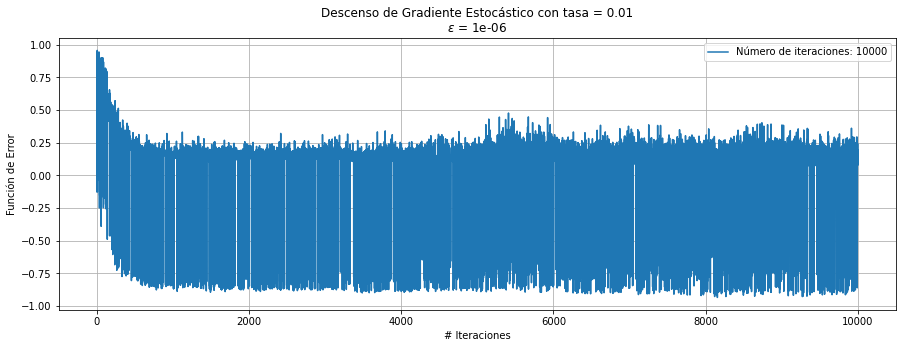

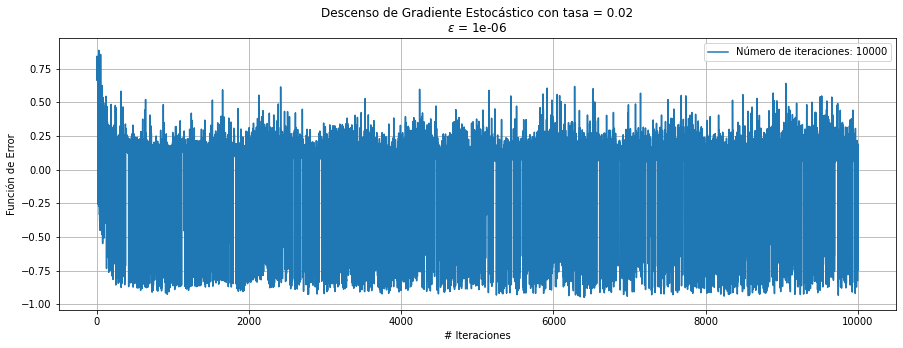

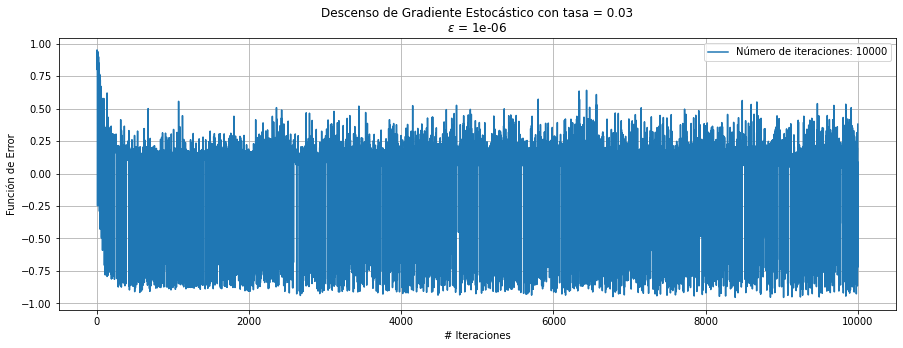

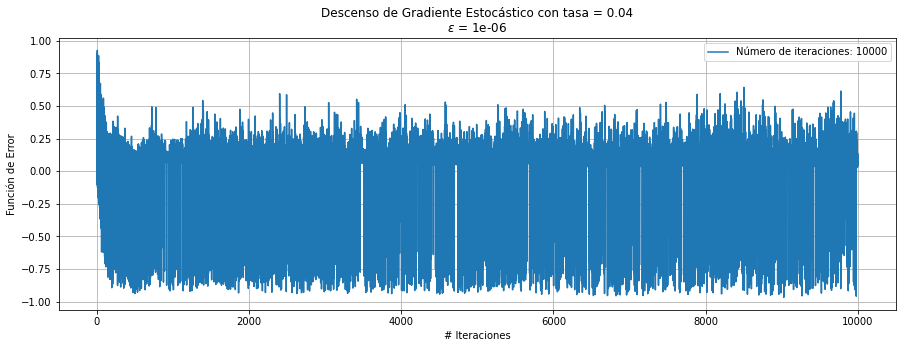

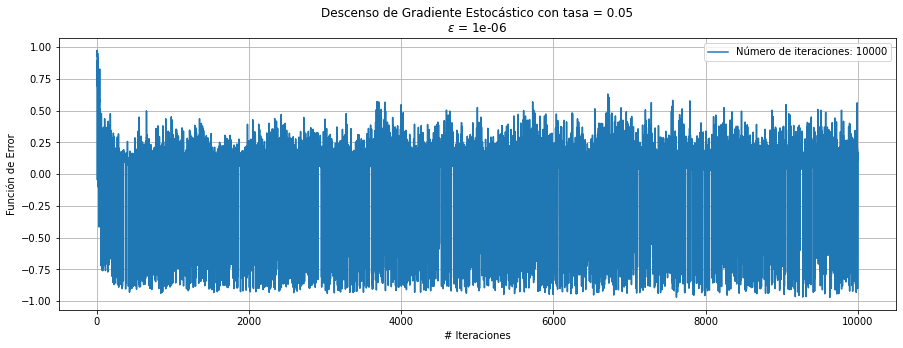

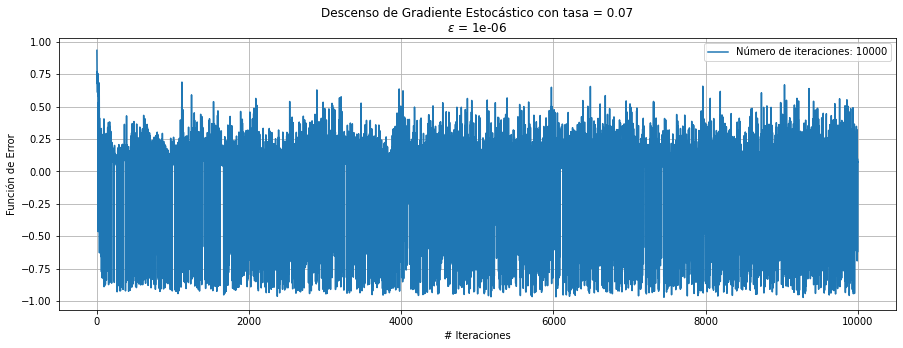

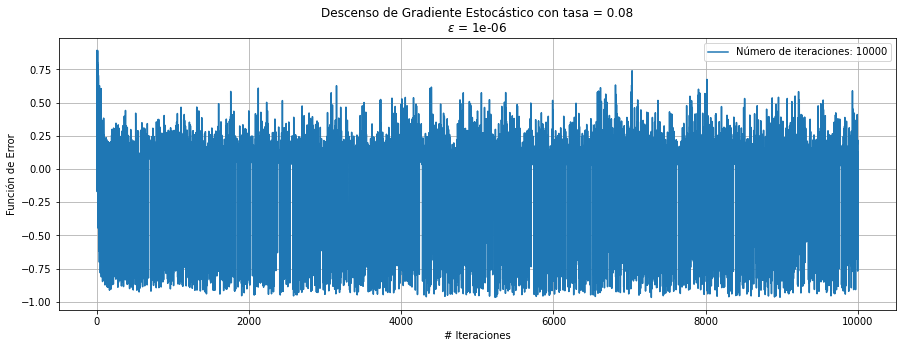

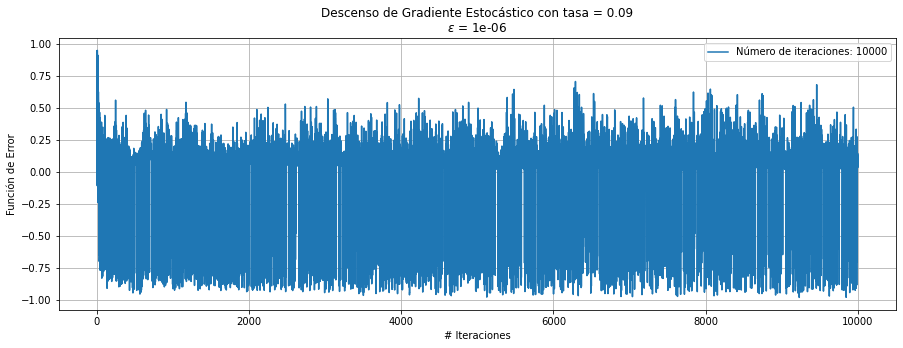

In [ ]:
np.random.seed(22)
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-6

def sigma(w,x):
    res_sigmoid = 1/(1+np.exp(np.matmul(-w.T, x))) # Salida de la función sigmoide #
    return res_sigmoid

# Listas para monitorear aprendizaje
errores = []
ypreds = []
recalls = []

tasas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09] # Defina un vector que contenga las tasas que desea probar #

for tasa in tasas:

    w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #
    w = w0.copy()
    w = np.asarray(np.matrix(w)).T
    dif = 100

    # while dif > eps:         # Criterio de parada 1 #
    for j in range (0, 10000):  # Criterio de parada 2 #
        # # Desarrollo de algoritmo # #

        # Selección de par aleatorio
        i = np.random.randint(low=0, high=y_train_array.shape[0]) # Posición aleatoria #
        xActual = np.matrix(np.array(X_train_array[i])).T
        yActual = np.matrix(np.array(y_train_array[i])).T
        
        # Calcular el gradiente y el error
        grad = sigma(w, xActual)
        e = grad - yActual
        
        # Calcular el vector de parámetros para la iteración actual
        w_nuevo = w - tasa*float(e)*xActual
        
        # Cálculo de la diferencia entre el w de la iteración actual con el de la anterior
        dif = np.linalg.norm(w-w_nuevo)
        
        # Se agrega el error a la lista de errores
        errores.append(float(e))

        # Actualización del valor de los parámetros
        w = w_nuevo
        
        # # # # # # # # # # # # # #
                
    X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
    y_test_array = y_test.values

    y_pred = np.zeros(len(x_test))

    for i in range(0,len(x_test)):
        prob = sigma(w,X_test_array[i])
        if prob>0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

    ypreds.append(y_pred)

    # Gráficas de Resultados
    plt.figure(figsize=(15,5))
    plt.plot(errores)
    plt.xlabel('# Iteraciones')
    plt.ylabel('Función de Error')
    plt.title(f'Descenso de Gradiente Estocástico con tasa = {tasa}\n' + r'$\epsilon$ = ' + f'{eps}')
    plt.legend([f'Número de iteraciones: {len(errores)}'])
    plt.grid()


    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm3 = confusion_matrix(y_test, y_pred)

    print(f'Para una tasa de {tasa}:\n')
    print(f'Matriz de confusión del modelo:\n {cm3}')
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)
    recalls.append(sensitivity)
    fpr = 1 - specificity
    print(f'\nSensitividad: {np.round(sensitivity, 4)}')
    print(f'\nFalsos negativos: {fn}\n')
    print('-----------------------------------\n')
    
    errores = [] # Vaciar la lista para graficar con la siguiente tasa.

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

Mejor sensitivity: 0.1167 con tasa 0.08


Especificidad = 0.981

TPR = Sensitividad = 0.1167

FPR = 1 - Especificidad = 0.019

Falsos positivos: 12.

Falsos negativos: 106.


Matriz de confusión para este caso:


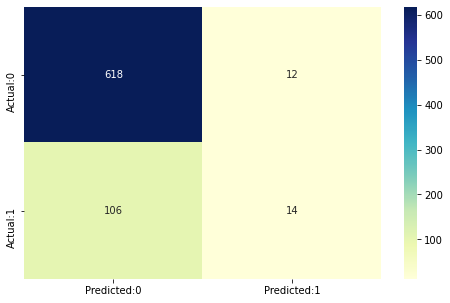

In [ ]:
index_mejor = recalls.index(max(recalls))
y_pred_mejor = ypreds[index_mejor]
print(f'Mejor sensitivity: {np.round(recalls[index_mejor], 4)} con tasa {tasas[index_mejor]}\n\n')

cm = confusion_matrix(y_test,y_pred_mejor)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

print(f'Especificidad = {np.round(cm[0,0]/(float(cm[0,0]+cm[0,1])), 4)}\n')
print(f'TPR = Sensitividad = {np.round(cm[1,1]/(float(cm[1,1]+cm[1,0])), 4)}\n')
print(f'FPR = 1 - Especificidad = {np.round(1-(cm[0,0]/(float(cm[0,0]+cm[0,1]))), 4)}\n')
print(f'Falsos positivos: {cm[0,1]}.\n')
print(f'Falsos negativos: {cm[1,0]}.\n')
print('\nMatriz de confusión para este caso:')

## Conclusiones

Despúes de hacer la prueba del algoritmo de descenso de gradiente estocástico para diferentes tasas de aprendizaje, se escogió el modelo con una mayor sensitividad ya que nuestro modelo tiene un alto costo asociado a los falsos negativos. Lo anterior se debe a que, como ya se mencionó previamente, si se determina que un paciente no se encuentra enfermo pero sí lo está, las consecuencias pueden ser muy graves. Este modelo **corresponde a una tasa de aprendizaje de 0.08**, pues con esta tasa se encontró que se disminuyó el número de falsos negativos con respecto a lo obtenido en la Parte 1 con la función `LogisticRegression` de SciKit-Learn. 

Sin embargo, no se logró una disminución ideal para el contexto del problema, pero se puede decir que es debido a una razón diferente al modelo de regresión logística realizado, como lo puede ser el número de datos con el que se entrenó el modelo. Esto ya que en los diferentes métodos de regresión logística utilizados (la función `LogisticRegression`, probabilidades con umbral y de forma manual con el descenso de gradiente estocástico) no se obtuvo en ningún caso un número bajo de falsos negativos (menor a 10).